# 01 - Physics Validation: Gaussian Random Fields

This notebook validates our universe simulator by visualizing:
1. Generated density fields for different $\Omega_m$ values
2. The power spectrum $P(k)$ and its dependence on cosmological parameters
3. Statistical properties of the generated fields

**Goal:** Build intuition for what the neural network "sees" and must learn.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import sys
sys.path.append('..')

from src.physics import (
    generate_universe, 
    primordial_power_spectrum,
    bbks_transfer_function,
    compute_power_spectrum_2d
)

# Style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['font.size'] = 11

Matplotlib is building the font cache; this may take a moment.


## 1. The Transfer Function $T(k)$

The BBKS transfer function encodes how primordial fluctuations are processed by sub-horizon physics. It acts as a **low-pass filter**: small scales (large $k$) are suppressed.

The key parameter is $\Gamma = \Omega_m h$, which sets the **equality scale** $k_{eq}$ where radiation and matter energy densities were equal.

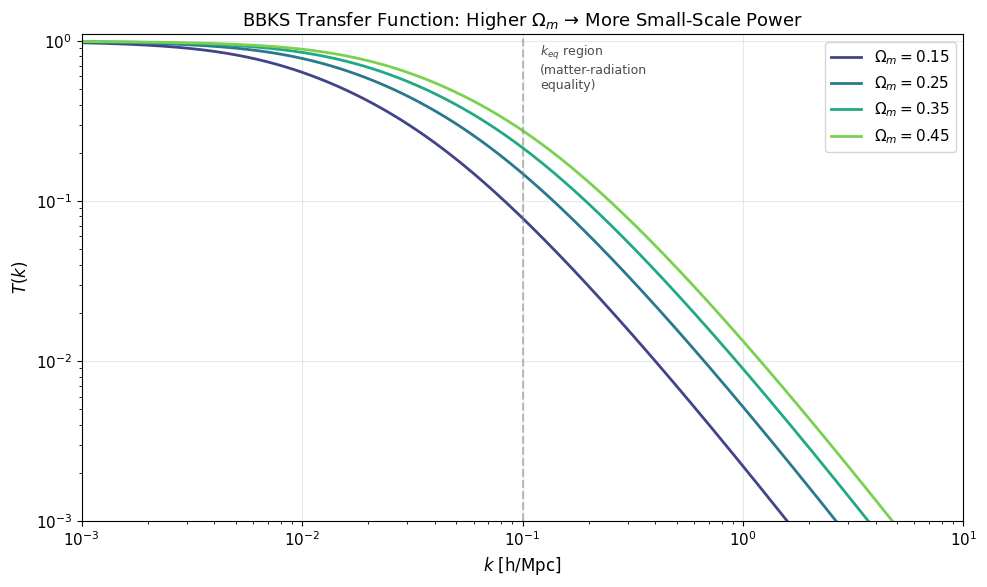

In [2]:
# Visualize the transfer function for different Omega_m
k = np.logspace(-3, 1, 500)  # k in h/Mpc

fig, ax = plt.subplots(figsize=(10, 6))

omega_m_values = [0.15, 0.25, 0.35, 0.45]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(omega_m_values)))

for omega_m, color in zip(omega_m_values, colors):
    T_k = bbks_transfer_function(k, omega_m)
    ax.loglog(k, T_k, label=f'$\\Omega_m = {omega_m}$', color=color, lw=2)

ax.set_xlabel('$k$ [h/Mpc]', fontsize=12)
ax.set_ylabel('$T(k)$', fontsize=12)
ax.set_title('BBKS Transfer Function: Higher $\\Omega_m$ → More Small-Scale Power', fontsize=13)
ax.legend(fontsize=11)
ax.set_xlim(1e-3, 10)
ax.set_ylim(1e-3, 1.1)

# Annotate the physics
ax.axvline(x=0.1, color='gray', linestyle='--', alpha=0.5)
ax.text(0.12, 0.5, '$k_{eq}$ region\n(matter-radiation\nequality)', fontsize=9, alpha=0.7)

plt.tight_layout()
plt.show()

## 2. The Matter Power Spectrum $P(k)$

The full power spectrum is:
$$P(k) = A_s \cdot k^{n_s} \cdot T^2(k)$$

- $A_s \approx 2.1 \times 10^{-9}$: primordial amplitude (from inflation)
- $n_s \approx 0.965$: spectral index (slight red tilt)
- $T(k)$: transfer function (encodes $\Omega_m$ dependence)

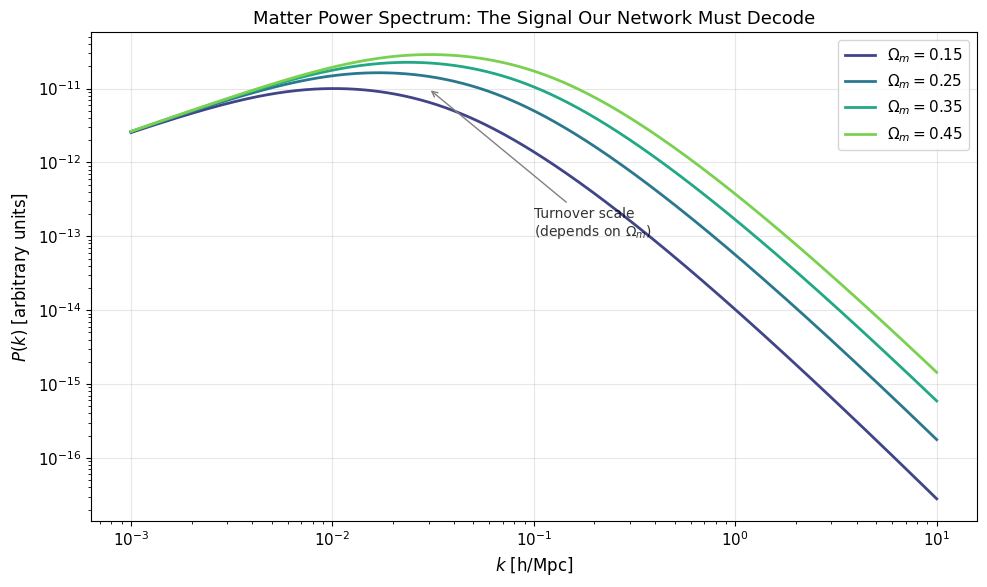

In [3]:
# Visualize P(k) for different Omega_m
fig, ax = plt.subplots(figsize=(10, 6))

for omega_m, color in zip(omega_m_values, colors):
    P_k = primordial_power_spectrum(k, omega_m)
    ax.loglog(k, P_k, label=f'$\\Omega_m = {omega_m}$', color=color, lw=2)

ax.set_xlabel('$k$ [h/Mpc]', fontsize=12)
ax.set_ylabel('$P(k)$ [arbitrary units]', fontsize=12)
ax.set_title('Matter Power Spectrum: The Signal Our Network Must Decode', fontsize=13)
ax.legend(fontsize=11)

# Show the turnover
ax.annotate('Turnover scale\n(depends on $\\Omega_m$)', 
            xy=(0.03, 1e-11), xytext=(0.1, 1e-13),
            arrowprops=dict(arrowstyle='->', color='gray'),
            fontsize=10, alpha=0.8)

plt.tight_layout()
plt.show()

## 3. Generated Density Fields

Now let's visualize actual realizations of the density field $\delta(\mathbf{x})$ for different $\Omega_m$ values.

Each field is a **Gaussian Random Field**: the Fourier modes have random phases, and the amplitude at each $k$ is drawn from a distribution determined by $P(k)$.


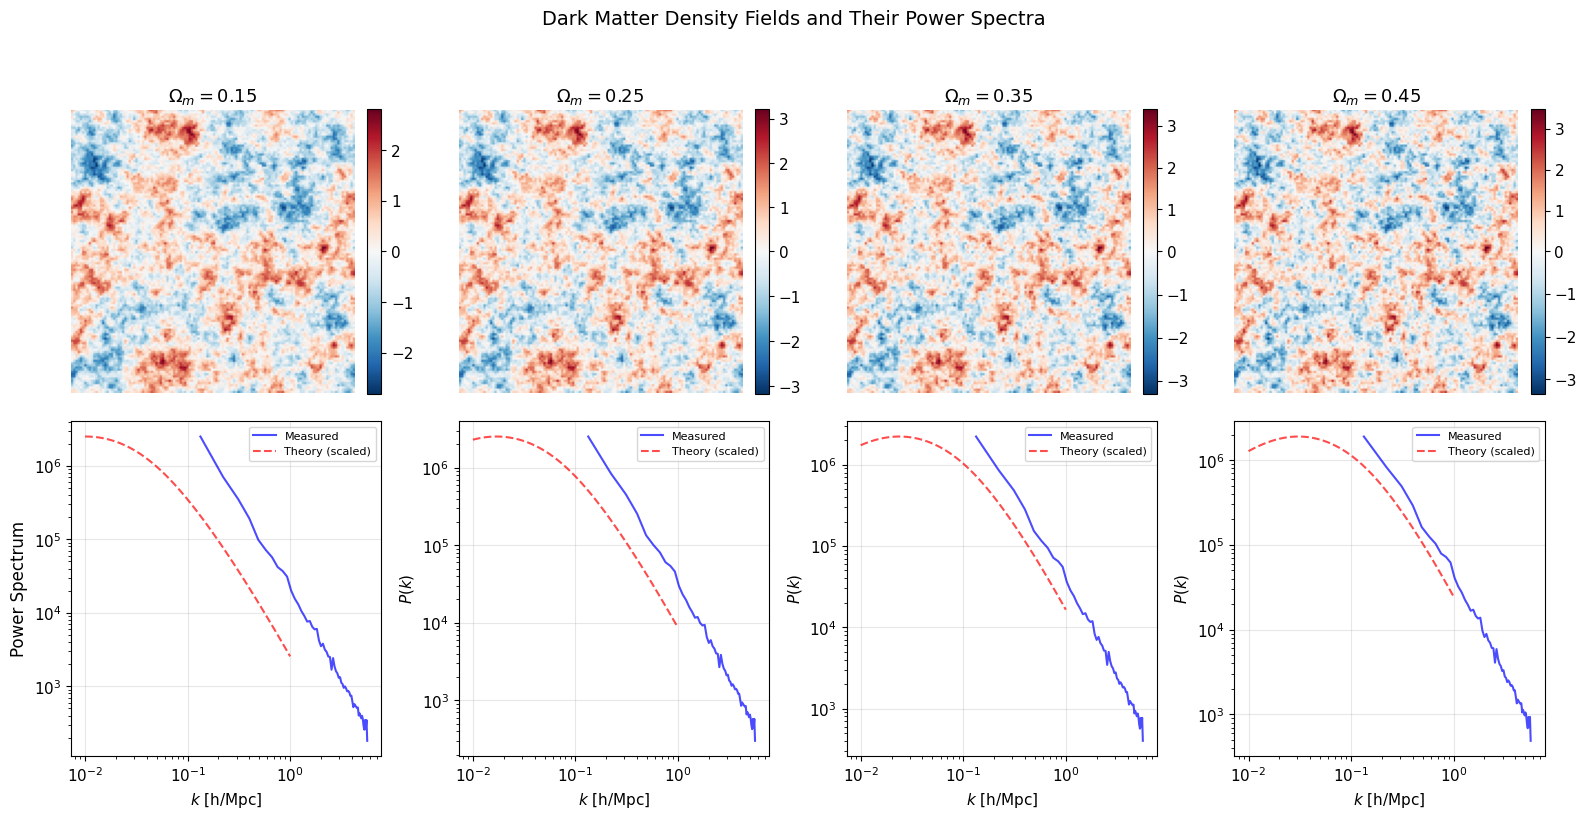

In [9]:
# Generate fields for different Omega_m values
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

omega_m_values = [0.15, 0.25, 0.35, 0.45]
seeds = [42, 42, 42, 42]  # Same seed to compare structure, not random variation

for i, (omega_m, seed) in enumerate(zip(omega_m_values, seeds)):
    # Generate field
    field = generate_universe(omega_m, size=128, seed=seed)
    
    # Top row: density field
    ax = axes[0, i]
    norm = TwoSlopeNorm(vmin=field.min(), vcenter=0, vmax=field.max())
    im = ax.imshow(field, cmap='RdBu_r', norm=norm, origin='lower')
    ax.set_title(f'$\\Omega_m = {omega_m}$', fontsize=13)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Bottom row: power spectrum of this realization
    ax = axes[1, i]
    k_bins, P_k_measured = compute_power_spectrum_2d(field, box_size=100.0)
    ax.loglog(k_bins[1:], P_k_measured[1:], 'b-', lw=1.5, alpha=0.7, label='Measured')
    
    # Overlay theoretical
    k_theory = np.logspace(-2, 0, 100)
    P_theory = primordial_power_spectrum(k_theory, omega_m)
    P_theory = P_theory / P_theory.max() * P_k_measured[1:].max()  # Normalize for comparison
    ax.loglog(k_theory, P_theory, 'r--', lw=1.5, alpha=0.7, label='Theory (scaled)')
    
    ax.set_xlabel('$k$ [h/Mpc]')
    ax.set_ylabel('$P(k)$')
    ax.legend(fontsize=8)

axes[0, 0].set_ylabel('Density Field $\\delta(x)$', fontsize=12)
axes[1, 0].set_ylabel('Power Spectrum', fontsize=12)

plt.suptitle('Dark Matter Density Fields and Their Power Spectra', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 4. Statistical Validation

For a **Gaussian Random Field**, the pixel values should follow a Gaussian distribution (after normalization to zero mean, unit variance).

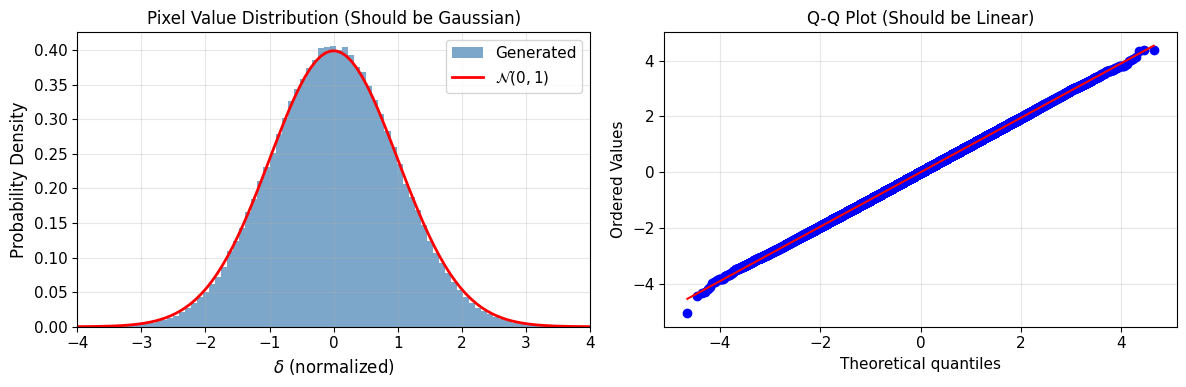

Statistics from 100 realizations:
  Mean: 0.0000 (expected: 0)
  Std:  0.9765 (expected: 1)
  Skewness: 0.0081 (expected: 0)
  Kurtosis: -0.0256 (expected: 0)


In [5]:
# Generate many realizations and check statistics
n_realizations = 100
omega_m_test = 0.3

all_pixels = []
for i in range(n_realizations):
    field = generate_universe(omega_m_test, size=64, seed=None)
    all_pixels.extend(field.flatten())

all_pixels = np.array(all_pixels)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
ax = axes[0]
ax.hist(all_pixels, bins=100, density=True, alpha=0.7, color='steelblue', label='Generated')

# Overlay Gaussian
x = np.linspace(-4, 4, 100)
gaussian = np.exp(-x**2/2) / np.sqrt(2*np.pi)
ax.plot(x, gaussian, 'r-', lw=2, label='$\\mathcal{N}(0, 1)$')

ax.set_xlabel('$\\delta$ (normalized)', fontsize=12)
ax.set_ylabel('Probability Density', fontsize=12)
ax.set_title('Pixel Value Distribution (Should be Gaussian)', fontsize=12)
ax.legend()
ax.set_xlim(-4, 4)

# Q-Q plot
ax = axes[1]
from scipy import stats
stats.probplot(all_pixels, dist="norm", plot=ax)
ax.set_title('Q-Q Plot (Should be Linear)', fontsize=12)

plt.tight_layout()
plt.show()

print(f"Statistics from {n_realizations} realizations:")
print(f"  Mean: {all_pixels.mean():.4f} (expected: 0)")
print(f"  Std:  {all_pixels.std():.4f} (expected: 1)")
print(f"  Skewness: {stats.skew(all_pixels):.4f} (expected: 0)")
print(f"  Kurtosis: {stats.kurtosis(all_pixels):.4f} (expected: 0)")

## 5. The Inverse Problem Challenge

The neural network must solve the **inverse problem**: given a realization $\delta(\mathbf{x})$, estimate $\Omega_m$.

This is challenging because:
1. Each realization is **random** (different phases)
2. The signal is in the **statistics** (power spectrum shape), not individual pixels
3. We have **finite resolution** (64×64 pixels)

Let's see if we can visually distinguish fields with different $\Omega_m$:

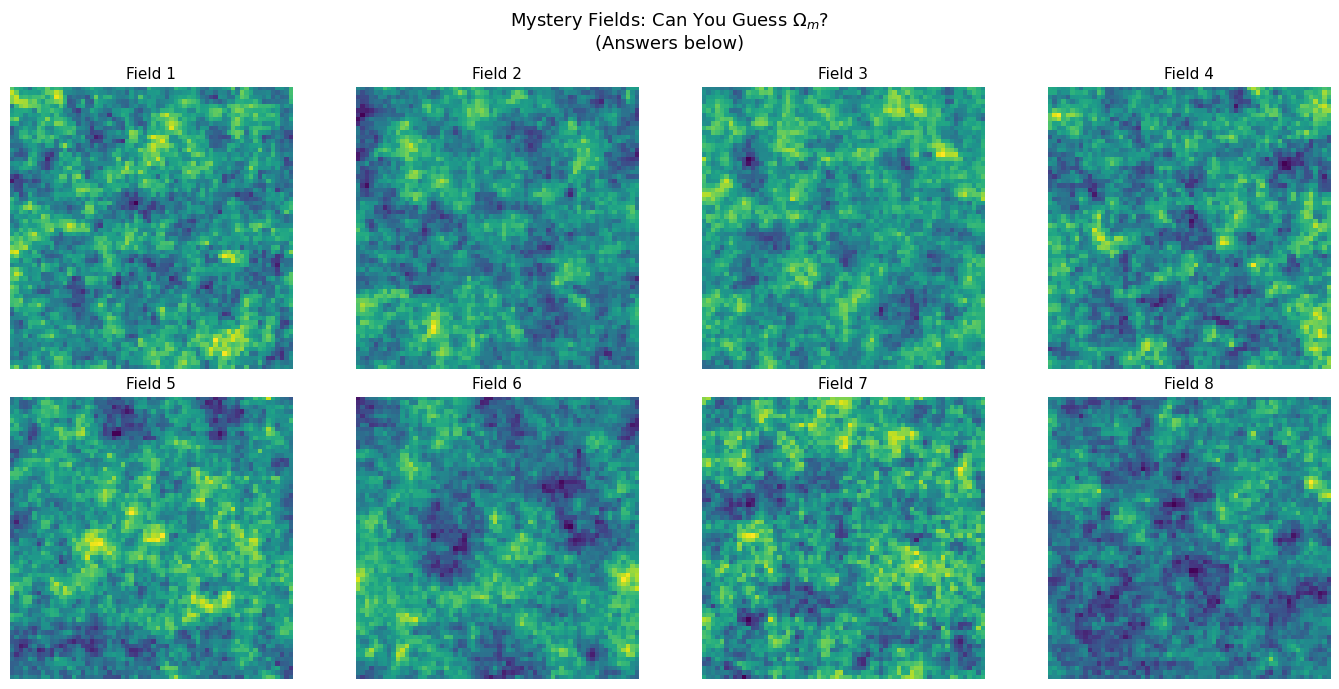


Answers:
  Field 1: Ωm = 0.359
  Field 2: Ωm = 0.236
  Field 3: Ωm = 0.218
  Field 4: Ωm = 0.315
  Field 5: Ωm = 0.366
  Field 6: Ωm = 0.277
  Field 7: Ωm = 0.444
  Field 8: Ωm = 0.355


In [6]:
# Can you tell which is which?
fig, axes = plt.subplots(2, 4, figsize=(14, 7))

# Random omega_m values
np.random.seed(123)
omega_m_hidden = np.random.uniform(0.15, 0.45, 8)

for idx, (ax, om) in enumerate(zip(axes.flat, omega_m_hidden)):
    field = generate_universe(om, size=64)
    ax.imshow(field, cmap='viridis', origin='lower')
    ax.set_title(f'Field {idx+1}', fontsize=11)
    ax.axis('off')

plt.suptitle('Mystery Fields: Can You Guess $\\Omega_m$?\n(Answers below)', fontsize=13)
plt.tight_layout()
plt.show()

# Reveal answers
print("\nAnswers:")
for idx, om in enumerate(omega_m_hidden):
    print(f"  Field {idx+1}: Ωm = {om:.3f}")

## Summary

### Key Takeaways:

1. **The physics is encoded in $P(k)$**: Different $\Omega_m$ values produce different power spectrum shapes

2. **The challenge is statistical**: Individual realizations look similar; the signal is in ensemble statistics

3. **The CNN must learn**: To extract power spectrum information from single realizations

### What the Network Learns:

The convolutional layers learn **local patterns** that correlate with $\Omega_m$:
- Higher $\Omega_m$ → more small-scale power → more fine structure
- Lower $\Omega_m$ → less small-scale power → smoother fields

The pooling layers perform **coarse graining**, extracting features at multiple scales—exactly what's needed to probe the power spectrum shape.

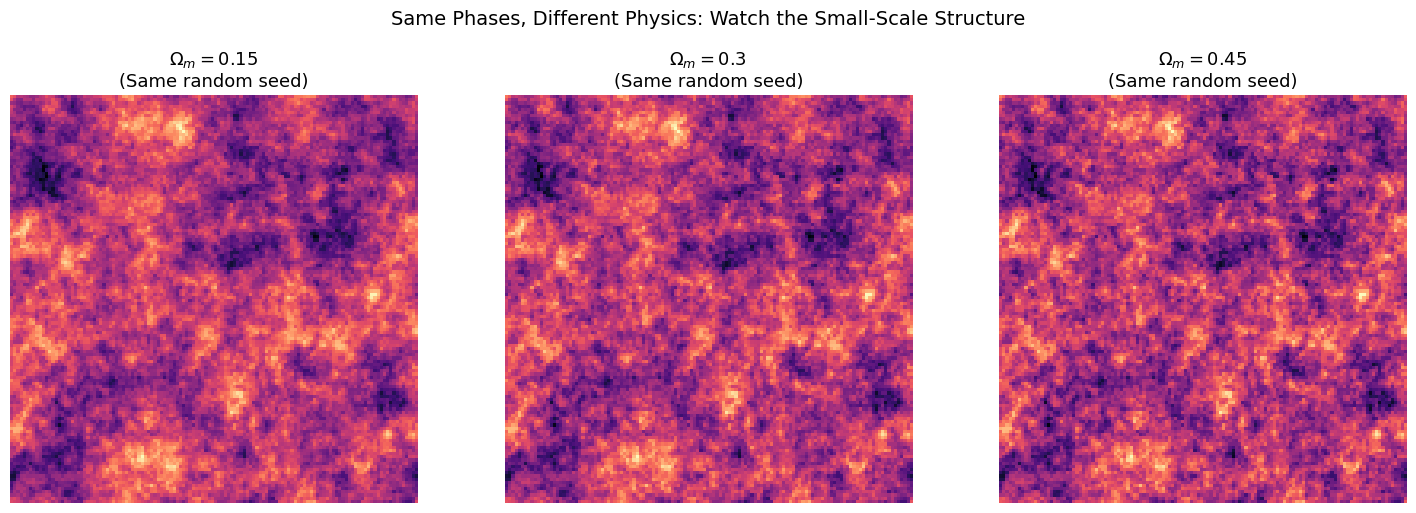

Notice: Higher Ωm → More fine-grained structure (more small-scale power)


In [7]:
# Final demonstration: the structure difference
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Same random seed, different Omega_m
seed = 42

for ax, om in zip(axes, [0.15, 0.30, 0.45]):
    field = generate_universe(om, size=128, seed=seed)
    ax.imshow(field, cmap='magma', origin='lower')
    ax.set_title(f'$\\Omega_m = {om}$\n(Same random seed)', fontsize=13)
    ax.axis('off')

plt.suptitle('Same Phases, Different Physics: Watch the Small-Scale Structure', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Notice: Higher Ωm → More fine-grained structure (more small-scale power)")